# Inverse Kinematics (2D)

In [10]:
%matplotlib notebook
from matplotlib import pylab as plt
from numpy import sin, cos, pi, matrix, random
from __future__ import division
from math import atan2
from IPython import display
from ipywidgets import interact, fixed

## Coordinate Transformation

In [11]:
def trans(x, y, a):
    '''create a 2D transformation'''
    s = sin(a)
    c = cos(a)
    return matrix([[c, -s, x],
                   [s,  c, y],
                   [0,  0, 1]])

def from_trans(m):
    '''get x, y, theta from transform matrix'''
    return [m[0, -1], m[1, -1], atan2(m[1, 0], m[0, 0])]

In [12]:
trans(0, 0, 0)

matrix([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])

## Parameters of robot arm

In [13]:
N = 3  # number of links
l = [0] + list(range(N, 0, -1))  # length of link, l[0] is ingored
max_len = sum(l)
a = random.random_sample(N)  # angles of joints
T0 = trans(0, 0, 0)  # base

## Forward Kinematics

In [14]:
def forward_kinematics(T0, l, a):
    T = [T0]
    for i in range(len(a)):
        Ti = T[-1] * trans(l[i], 0, a[i])
        T.append(Ti)
    Te = T[-1] * trans(l[-1], 0, 0)  # end effector
    T.append(Te)
    return T

In [15]:
def show_robot_arm(T):
    plt.cla()
    x = [Ti[0,-1] for Ti in T]
    y = [Ti[1,-1] for Ti in T]
    plt.plot(x, y, '-or', linewidth=5, markersize=10)
    plt.plot(x[-1], y[-1], 'og', linewidth=5, markersize=10)
    plt.xlim([-max_len, max_len])
    plt.ylim([-max_len, max_len]) 
    ax = plt.axes()
    ax.set_aspect('equal')
    t = atan2(T[-1][1, 0], T[-1][0,0])
    ax.annotate('[%.2f,%.2f,%.2f]' % (x[-1], y[-1], t), xy=(x[-1], y[-1]), xytext=(x[-1], y[-1] + 0.5))
    plt.show()

## Inverse Kinematics

## Analytical Solutions with Sympy

[SymPy](http://sympy.org/) is a Python library for symbolic mathematics.

In [16]:
from sympy import init_printing, sin, cos, pi, asin, acos, atan2, atan, sqrt, simplify, solve, latex, symbols
from sympy import Matrix as matrix
init_printing()

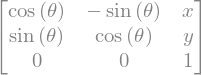

In [17]:
from sympy.abc import x, y, theta
trans(x, y, theta)


In [18]:
N = 3
l = [symbols('l_%d' % i) for i in range(N + 1)]
l[0] = 0
a = [symbols('theta_%d' % i) for i in range(N)]

T0 = trans(0, 0, 0)

In [19]:
l, a

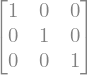

In [20]:
T0

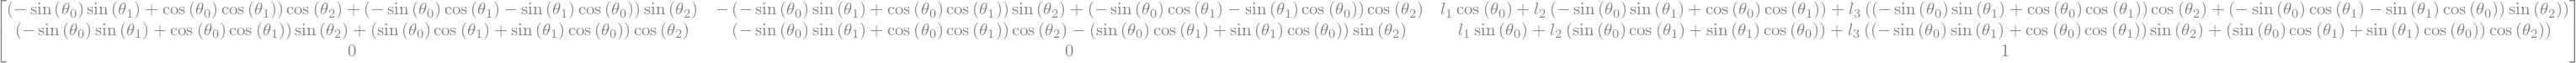

In [21]:
T = forward_kinematics(T0, l, a)
Te = T[-1]
Te

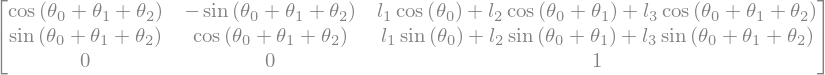

In [22]:
Te = simplify(Te)
Te

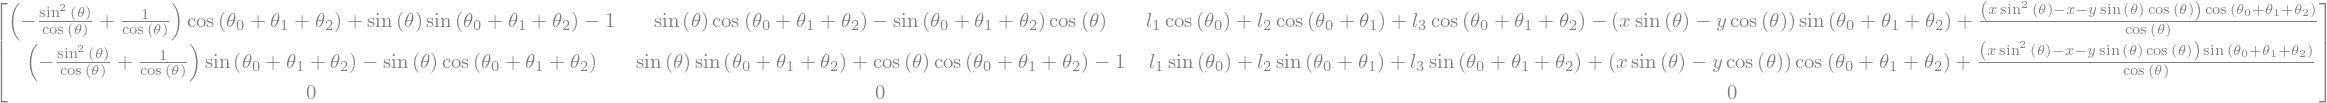

In [23]:
# Te = T0 * trans(x, y, theta)
# T0 * trans(x, y, theta) - Te = 0
# Te * trans(x, y, theta).inv() - T0 = 0
eq = Te * trans(x, y, theta).inv() - T0
eq

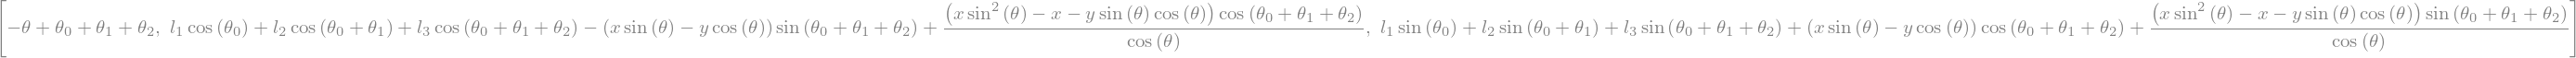

In [24]:
eq = [a[0] + a[1] + a[2] - theta, eq[0, 2], eq[1, 2]]
eq

In [ ]:
solve(eq, a)  # sympy is too stupid to solve it

### cosine rule

In [ ]:
# now we use cosine rule to solve the equation

b = [symbols('theta_%d' % i) for i in range(N)]  # target angles
T3 = trans(x, y, theta) * trans(l[3], 0, 0).inv()
l_1_2 = T3[0,-1] ** 2 + T3[1,-1] ** 2
b_1_2 = acos((l[1] ** 2 + l[2] ** 2 - l_1_2) / (2 * l[1] * l[2]))  # cosine rule
b[1] = pi - b_1_2
b_1 = acos((l[1] ** 2 - l[2] ** 2 + l_1_2) / (2 * l[1] * sqrt(l_1_2)))  # cosine rule
b_0 = atan(T3[1,-1] / T3[0,-1])
b[0] = b_0 - b_1
b[2] = atan(T3[1,0] / T3[0,0]) - b[0] - b[1]
B = matrix([b]).T
B = simplify(B)
B  # vector of target angles, e.g. [theta_0, theta_1, theta_2]

In [ ]:
# print latex(B)

In [ ]:
# validate the results by forward kinematics

T_new = forward_kinematics(T0, l, b)
Te_new = T_new[-1]
Te_new  # should be same as Te, e.g. trans(x, y, theta)

In [ ]:
# we could simplify the result, but Sympy can't give result
# simplify(Te_new[0, 0])  # --> cos(theta)

In [ ]:
# simplify(Te_new[1, 0])  # --> sin(theta)

In [ ]:
# simplify(Te_new[0, -1])  # --> x

### Test the analytical solution

In [ ]:
from numpy import sin, cos, pi, matrix, random
from math import atan2, acos

T0 = trans(0, 0, 0)
lv = [0, 3, 2, 1]  # length of link, l[0] is ingored
bf = B
for i in range(N):
    bf = bf.subs(l[i + 1], lv[i + 1])

def inverse_kinematics(x_e, y_e, theta_e):
    b = bf.subs(x, x_e).subs(y, y_e).subs(theta, theta_e)
    b = (b.subs('I', 1).subs('pi', pi).tolist())
    b = [float(i[0]) for i in b]
    return b

T = forward_kinematics(T0, lv, random.random(N))
show_robot_arm(T)
@interact(x_e=(0, max_len, 0.1), y_e=(-max_len, max_len, 0.1), theta_e=(-pi, pi, 0.1))
def set_end_effector(x_e=5, y_e=0, theta_e=0):
    b = inverse_kinematics(x_e, y_e, theta_e)
    T = forward_kinematics(T0, lv, b)
    show_robot_arm(T)